In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import gzip
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from urllib.request import urlopen

In [218]:
import time

In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [219]:
rdata = pd.read_csv("D:/jupyter/pymagic/e-commerce RecSys/ratings_CDs_and_Vinyl.csv",names=['user_id','product_id','rating','timestamp'])

In [220]:
rdata

,user_id,product_id,rating,timestamp
0,A9DMTMLFR9CO5,0001393774,5.0,1377907200
1,AHG1GTQZUYNJN,0001393774,5.0,1372723200
2,A2TFO7NREP2B2D,0001393774,5.0,1396396800
3,A2YAPAG1IPNK7K,0001393774,5.0,1392422400
4,AEKGGV851HY3K,0001393774,5.0,1130803200
...,...,...,...,...
3748999,A122G17YDFX176,B00LG9GR3S,5.0,1405382400
3749000,A26QVK35BBBKU8,B00LG9GR3S,5.0,1404777600
3749001,A1V76VMZ0N3H5W,B00LG9GR3S,5.0,1404864000
3749002,A248BRA9BLBUJ2,B00LH0CAT6,5.0,1404518400


In [6]:
rdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3749004 entries, 0 to 3749003
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     object 
 1   product_id  object 
 2   rating      float64
 3   timestamp   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 114.4+ MB


In [ ]:
#rdata = rdata.astype({col: 'int32' for col in df.select_dtypes('object').columns})

In [7]:
rdata.isnull().sum()

user_id       0
product_id    0
rating        0
timestamp     0
dtype: int64

In [221]:
unique_users = len(np.unique(rdata.user_id))
unique_pdts = len(np.unique(rdata.product_id))
print(f'Number of users in dataset: {unique_users}')
print(f'Number of products in dataset: {unique_pdts}')

Number of users in dataset: 1578597
Number of products in dataset: 486360


In [232]:
df_user = rdata[rdata.groupby('user_id')['user_id'].transform('size') >= 20]
df_user

,user_id,product_id,rating,timestamp
4,AEKGGV851HY3K,0001393774,5.0,1130803200
6,A12R54MKO17TW0,0001393774,5.0,1326067200
49,A3JAIZQ5RS064X,0307141144,5.0,993600000
54,A2AOZQ3WTNVVOK,030714142X,3.0,1143676800
65,A3IEV6R2B7VW5Z,0307141985,5.0,1128556800
...,...,...,...,...
3748919,A1B621EA66Z8KV,B00L326LTI,5.0,1405814400
3748951,A3UKLX2A9T589C,B00L326LTI,5.0,1405468800
3748974,ASEBX8TBYWQWA,B00L5MGHLI,4.0,1404950400
3748977,A1TR2CQMTNMC56,B00L5SFSN0,1.0,1405641600


In [233]:
df_item = df_user[df_user.groupby('product_id')['product_id'].transform('size') >= 20]
df_item

,user_id,product_id,rating,timestamp
1446,A2K3LZPH3ND94V,0780018664,4.0,1167868800
1448,AQS3Z062MTX0L,0780018664,1.0,1015200000
1449,A1GSR7RGCG1QYZ,0780018664,5.0,1249344000
1455,A2GANR9I6XHTU9,0780018664,4.0,1169337600
1457,ANCOMAI0I7LVG,0780018664,5.0,1213574400
...,...,...,...,...
3747245,AXHWQ834G3IUV,B00K5T1LZ4,5.0,1402963200
3747257,A182SY7I1OPU3A,B00K5T1LZ4,5.0,1405296000
3747268,AVN00ASBFTMN6,B00K5T1LZ4,3.0,1404518400
3747278,A3VAXB8CDYY5BG,B00K5T1LZ4,2.0,1402963200


In [235]:
ratings_per_user = df_item.groupby(by='user_id')['rating'].count().sort_values(ascending=False).to_frame().reset_index()
ratings_per_user = ratings_per_user.rename({'rating' : 'user_rating_counter'}, axis = 1)
ratings_per_user

,user_id,user_rating_counter
0,A9Q28YTLYREO7,1182
1,A3KJ6JAZPH382D,946
2,A8IFUOL8S9BZC,744
3,A2582KMXLK2P06,743
4,A26NLSTT75FMJM,716
...,...,...
14124,A1OP0NTJ1SOXKF,1
14125,A337V5X9P34IE3,1
14126,A1ORZKYPMHLRUC,1
14127,A2JD1IORKB585I,1


In [242]:
df = df_item.merge(ratings_per_user, on="user_id", how = 'inner')
df

,user_id,product_id,rating,timestamp,user_rating_counter
0,A2K3LZPH3ND94V,0780018664,4.0,1167868800,2
1,A2K3LZPH3ND94V,B000001FOD,4.0,1162512000,2
2,AQS3Z062MTX0L,0780018664,1.0,1015200000,1
3,A1GSR7RGCG1QYZ,0780018664,5.0,1249344000,7
4,A1GSR7RGCG1QYZ,B00005OAJ1,5.0,1120694400,7
...,...,...,...,...,...
273312,A2S0TMR69SMGC8,B00G5JCFEE,5.0,1394755200,1
273313,A2WD67QE1B6K95,B00HHYEOV8,5.0,1397865600,1
273314,A1FFRNXFNY1UG8,B00HHYEOV8,5.0,1397001600,1
273315,A26DDRSI90CWS,B00I0O9QJY,5.0,1398729600,1


In [246]:
df_fin_u = df[(df['user_rating_counter'] >= 20).groupby(df['user_id']).transform('any')]
df_fin_u

,user_id,product_id,rating,timestamp,user_rating_counter
10,A2GANR9I6XHTU9,0780018664,4.0,1169337600,38
11,A2GANR9I6XHTU9,1573300403,5.0,1073520000,38
12,A2GANR9I6XHTU9,B000000GPY,5.0,1052006400,38
13,A2GANR9I6XHTU9,B000000IVW,5.0,1078963200,38
14,A2GANR9I6XHTU9,B000000OSG,5.0,1079568000,38
...,...,...,...,...,...
273122,A24PMZJF0LHGCW,B00B4VXQC8,5.0,1363046400,29
273123,A24PMZJF0LHGCW,B00B69UQEO,5.0,1364256000,29
273124,A24PMZJF0LHGCW,B00BHRCD14,5.0,1365465600,29
273125,A24PMZJF0LHGCW,B00DAPOHWE,5.0,1401148800,29


In [247]:
product_sum_ratings =  df_fin_u.groupby(by='product_id')['rating'].count().sort_values(ascending=False).to_frame().reset_index()
product_sum_ratings = product_sum_ratings.rename({'rating' : 'product_rating_counter'}, axis = 1)
product_sum_ratings

,product_id,product_rating_counter
0,B000000IRB,316
1,B00008OWZG,307
2,B000002UAT,276
3,B000000IV0,274
4,B000002UB2,274
...,...,...
6503,B001BWQVW2,1
6504,B000GLKLCK,1
6505,B000001GYJ,1
6506,B00BSO2U1Y,1


In [249]:
df_fin_i = df_fin_u.merge(product_sum_ratings, on="product_id", how = 'inner')
df_fin_i

,user_id,product_id,rating,timestamp,user_rating_counter,product_rating_counter
0,A2GANR9I6XHTU9,0780018664,4.0,1169337600,38,21
1,ANCOMAI0I7LVG,0780018664,5.0,1213574400,177,21
2,A1GGOC9PVDXW7Z,0780018664,5.0,1268524800,64,21
3,A62G4QX6XQVLP,0780018664,5.0,1165190400,51,21
4,A2XKQHB8VCUCJK,0780018664,5.0,1385942400,27,21
...,...,...,...,...,...,...
190051,A2AIMXT9PLAM12,B000001G53,5.0,1127865600,25,2
190052,A328S9RN3U5M68,B00004TEUZ,5.0,1024444800,28,2
190053,A2AIMXT9PLAM12,B00004TEUZ,5.0,1128124800,25,2
190054,A37BJRKQPQ7Y54,B000GLKLCK,5.0,1276819200,24,1


In [250]:
df_fin_i.nunique()

user_id                   3713
product_id                6508
rating                       5
timestamp                 5741
user_rating_counter        250
product_rating_counter     173
dtype: int64

In [255]:
df_fin = df_fin_i[(df_fin_i['product_rating_counter'] >= 10).groupby(df_fin_i['product_id']).transform('any')]
df_fin.sort_values('product_rating_counter')

,user_id,product_id,rating,timestamp,user_rating_counter,product_rating_counter
179593,A1ZH9LWMX5UCFJ,B000066TPM,5.0,1031356800,51,10
84158,A9Q28YTLYREO7,B000002VTL,5.0,950400000,1182,10
84157,A3RNC9BGR4J1ZF,B000002VTL,5.0,1066780800,93,10
83945,A1K66EHHQ4MYX7,B000002UQN,5.0,1066867200,42,10
83944,AC1WHKYPIM3K1,B000002UQN,5.0,1189987200,26,10
...,...,...,...,...,...,...
19459,A1OKMIT8B373YD,B000000IRB,5.0,1066176000,66,316
19460,AS09CJ2GLNXNV,B000000IRB,5.0,1077321600,31,316
19461,A28X9KC4ZTMKZ7,B000000IRB,1.0,982108800,21,316
19335,A316COGDOL9D1L,B000000IRB,5.0,1132358400,37,316


In [253]:
df_fin.nunique()

user_id                   3713
product_id                6211
rating                       5
timestamp                 5741
user_rating_counter        250
product_rating_counter     164
dtype: int64

In [257]:
df_fin['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
df_fin

C:\Users\pdapr\AppData\Local\Temp/ipykernel_10808/3125470771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')


,user_id,product_id,rating,timestamp,user_rating_counter,product_rating_counter
0,A2GANR9I6XHTU9,0780018664,4.0,2007-01-04,38,21
1,ANCOMAI0I7LVG,0780018664,5.0,2006-11-03,177,21
2,A1GGOC9PVDXW7Z,0780018664,5.0,2002-03-04,64,21
3,A62G4QX6XQVLP,0780018664,5.0,2009-08-04,51,21
4,A2XKQHB8VCUCJK,0780018664,5.0,2005-07-07,27,21
...,...,...,...,...,...,...
190009,A2G0M8B7O6M0WX,B0000C23D6,1.0,2008-02-20,25,17
190010,AI1EUS7QNO54D,B0000C23D6,3.0,2007-05-23,29,17
190011,A23XEF9NW6PUIK,B0000C23D6,3.0,2006-06-02,45,17
190012,A125DOPLVT1HUD,B0000C23D6,2.0,2006-06-14,38,17


In [258]:
df_fin.groupby('product_id')['rating'].mean().sort_values(ascending=True)

product_id
B000BKSITO    1.178571
B0009ZE91M    1.210526
B000G04RLM    1.291667
B000IU3YLY    1.324324
B0000CD5F1    1.450000
                ...   
B00009N1ZV    5.000000
B000MTPANQ    5.000000
B0000BWVO3    5.000000
B000002VTL    5.000000
B00005QJFL    5.000000
Name: rating, Length: 6211, dtype: float64

In [267]:
df_fin.sort_values(by = 'user_rating_counter')

,user_id,product_id,rating,timestamp,user_rating_counter,product_rating_counter
105954,A3BEN3CQ8D1VW5,B000002VRQ,4.0,2014-04-22,20,17
69208,A2ZRMQU6BWOWQL,B000001EL1,5.0,2001-09-14,20,89
27109,A321C5I6V4R157,B000002J1S,5.0,2011-11-04,20,76
69226,A2CHIAR7FINYMS,B000001EL1,5.0,2002-07-24,20,89
27118,A3KZ8RF0NIJ6JF,B000002J1S,5.0,2010-10-19,20,76
...,...,...,...,...,...,...
96831,A9Q28YTLYREO7,B000007492,5.0,2012-01-05,1182,28
100535,A9Q28YTLYREO7,B00005K9KP,2.0,2000-11-01,1182,66
150033,A9Q28YTLYREO7,B0000041OG,5.0,2008-06-22,1182,10
84787,A9Q28YTLYREO7,B00007KQ70,5.0,2003-11-22,1182,24


# EDA

D:\programs\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


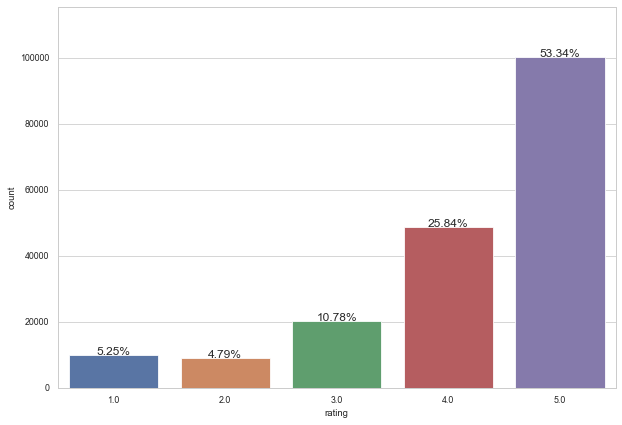

In [259]:
total = len(df_fin)
plt.figure(figsize = (10,7))
pl = sns.countplot(df_fin['rating'])

#for ax in patches:
sizes=[]

for p in pl.patches:
    height = p.get_height()
    sizes.append(height)
    pl.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=12) 
    
pl.set_ylim(0, max(sizes) * 1.15)

plt.show()

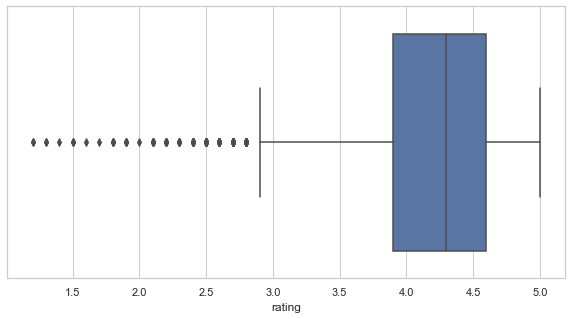

In [260]:
#items' mean rating
mean_rating = df_fin[['product_id','rating']].groupby('product_id').mean().sort_values('rating').round(1)
plt.figure(figsize = (10,5))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=mean_rating['rating'])
plt.show()

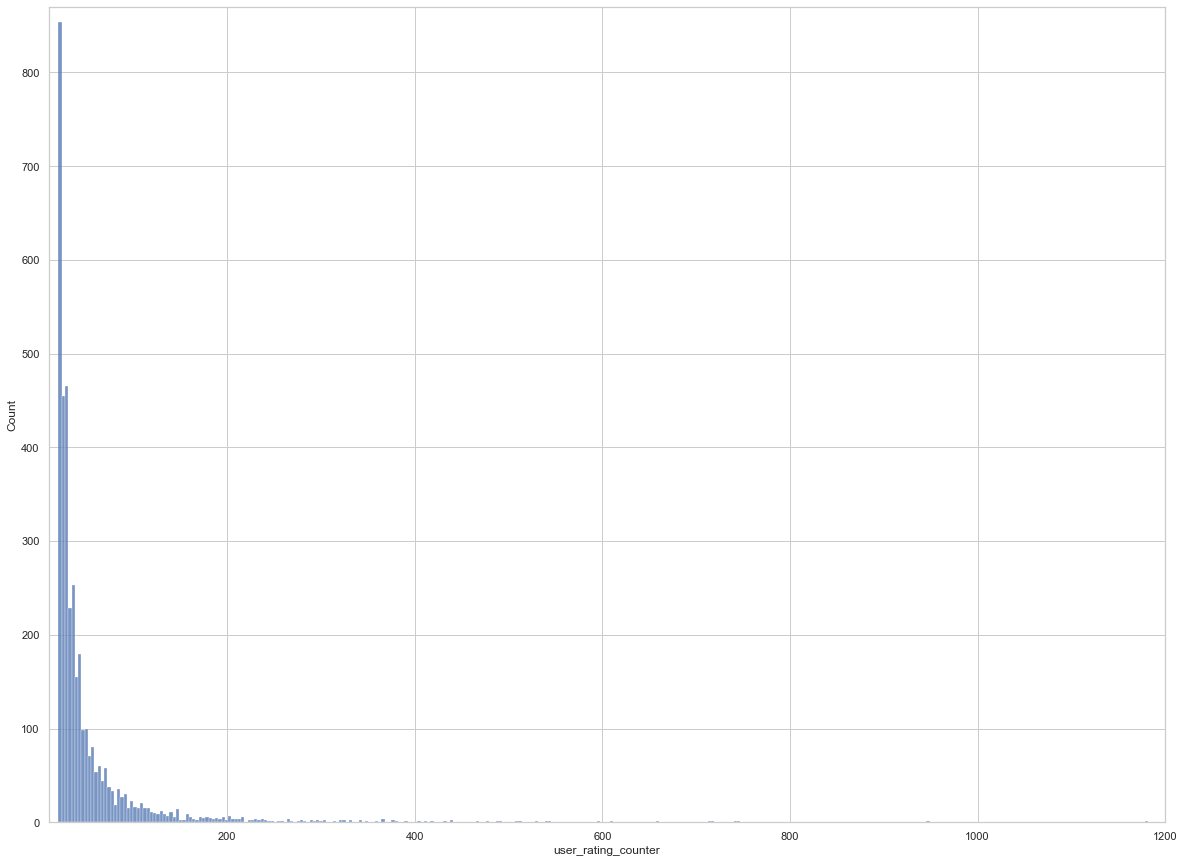

In [274]:
#number of users rating
us_r = df_fin[['user_id', 'user_rating_counter']].drop_duplicates('user_id').sort_values(by = 'user_rating_counter',ascending=True)

plt.figure(figsize = (20,15))
sns.set_theme(style="whitegrid")
ax = sns.histplot(x=us_r.user_rating_counter,stat = 'count')
ax.set(ylim=(0,870))
ax.set(xlim=(10, 1200))

plt.show()

D:\programs\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='timestamp', ylabel='count'>

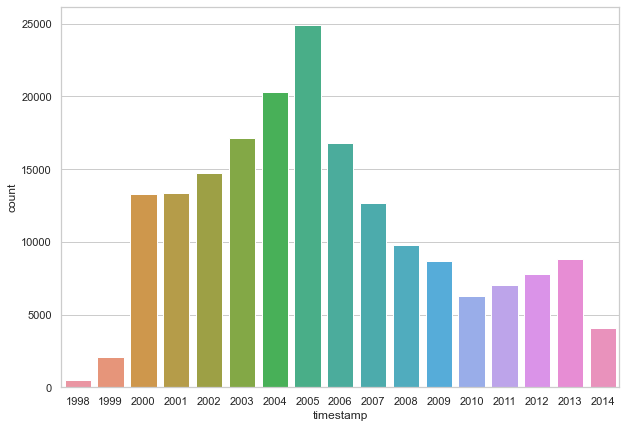

In [275]:
#count ratings per year
plt.figure(figsize = (10,7))
sns.countplot(df_fin['timestamp'].dt.year)

In [276]:
data_grouped = df_fin[['product_id','rating']].groupby('product_id').mean().reset_index()
df_grouped = data_grouped.merge(df_fin[['product_id', 'product_rating_counter']].drop_duplicates('product_id'),how='inner')
df_grouped

,product_id,rating,product_rating_counter
0,0780018664,4.809524,21
1,0780607287,4.714286,14
2,0788806270,4.757576,33
3,078881172X,4.730769,26
4,0790729350,4.548387,31
...,...,...,...
6206,B00IQE4NUK,3.285714,21
6207,B00J7UL6V6,4.250000,16
6208,B00JDB4PEY,4.037037,27
6209,B00JDB4PLM,4.230769,13


<Figure size 1080x720 with 0 Axes>

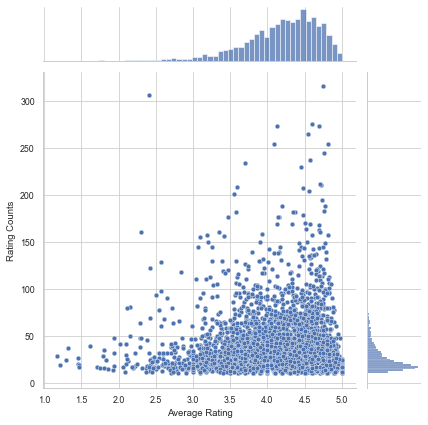

In [277]:
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="rating",y='product_rating_counter', kind='scatter',  data= df_grouped)
ax.set_axis_labels("Average Rating", "Rating Counts")
plt.show()

# Popularity based Recommender model

Non-personalised type of recommender systems. Can be a simple solution for new users with no history ('cold start problem'). This model recommends all users the same N items based on number of product ratings. 

## Basic Popularity Model

In [278]:
X_train, X_test = train_test_split(df_fin, test_size = 0.25, random_state = 42)

In [279]:
X_train.shape, X_test.shape

((141040, 6), (47014, 6))

In [280]:
data_grouped_tr = X_train[['product_id','rating']].groupby('product_id').mean().reset_index()
data_grouped_tr

,product_id,rating
0,0780018664,4.937500
1,0780607287,4.714286
2,0788806270,4.840000
3,078881172X,4.750000
4,0790729350,4.608696
...,...,...
6206,B00IQE4NUK,3.545455
6207,B00J7UL6V6,4.300000
6208,B00JDB4PEY,4.400000
6209,B00JDB4PLM,4.166667


In [281]:
df_grouped_tr = X_train[['product_id', 'product_rating_counter']].drop_duplicates('product_id').merge(data_grouped_tr, how = 'inner', on = 'product_id') 
df_grouped_tr.sort_values(by = 'product_rating_counter', ascending = False)

,product_id,product_rating_counter,rating
601,B000000IRB,316,4.730924
264,B00008OWZG,307,2.461207
514,B000002UAT,276,4.563636
217,B000002UB2,274,4.717073
672,B000000IV0,274,4.180905
...,...,...,...
5723,B000RIHBI4,10,2.800000
5720,B000007XUQ,10,5.000000
5715,B0027G783W,10,4.000000
4305,B0000047EG,10,5.000000


In [284]:
N_recommendations = 10
popularity_model = df_grouped_tr.sort_values(by = ['product_rating_counter', 'rating'], ascending = [0,0])
popularity_model.head(N_recommendations)

,product_id,product_rating_counter,rating
601,B000000IRB,316,4.730924
264,B00008OWZG,307,2.461207
514,B000002UAT,276,4.563636
217,B000002UB2,274,4.717073
672,B000000IV0,274,4.180905
432,B000002UAX,265,4.547739
1381,B000002UAR,254,4.861878
755,B000002H97,254,4.114130
1451,B000002H33,245,4.730159
299,B000002J09,237,4.568182


In [285]:
popularity_model

,product_id,product_rating_counter,rating
601,B000000IRB,316,4.730924
264,B00008OWZG,307,2.461207
514,B000002UAT,276,4.563636
217,B000002UB2,274,4.717073
672,B000000IV0,274,4.180905
...,...,...,...
5728,B00B4VXQC8,10,3.285714
5524,B00002MU53,10,3.166667
5940,B000CCXCTW,10,2.857143
5723,B000RIHBI4,10,2.800000


Assign rank to products from popularity model

In [286]:
#Generate a recommendation rank based upon score 
popularity_model['rank'] = popularity_model['product_rating_counter'].rank(ascending=0, method='first')
popularity_model
#Get the top 5 recommendations 
ranking_recommendations = popularity_model.head(10) 
ranking_recommendations 

,product_id,product_rating_counter,rating,rank
601,B000000IRB,316,4.730924,1.0
264,B00008OWZG,307,2.461207,2.0
514,B000002UAT,276,4.563636,3.0
217,B000002UB2,274,4.717073,4.0
672,B000000IV0,274,4.180905,5.0
432,B000002UAX,265,4.547739,6.0
1381,B000002UAR,254,4.861878,7.0
755,B000002H97,254,4.114130,8.0
1451,B000002H33,245,4.730159,9.0
299,B000002J09,237,4.568182,10.0


In [287]:
def recommendation(user_ID, N_recommendations):
    user_recommendations = popularity_model.head(N_recommendations)
          
    cols = user_recommendations.columns.tolist() 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [288]:
users = X_train['user_id'].sample(n = 3).tolist()

for i in users:
    print(f"Here is recommendations for user: {i}")
    print(recommendation(i,10))    
    print("\n")

Here is recommendations for user: A16Z3HTUIYPDH8
      product_id  product_rating_counter    rating  rank
601   B000000IRB                     316  4.730924   1.0
264   B00008OWZG                     307  2.461207   2.0
514   B000002UAT                     276  4.563636   3.0
217   B000002UB2                     274  4.717073   4.0
672   B000000IV0                     274  4.180905   5.0
432   B000002UAX                     265  4.547739   6.0
1381  B000002UAR                     254  4.861878   7.0
755   B000002H97                     254  4.114130   8.0
1451  B000002H33                     245  4.730159   9.0
299   B000002J09                     237  4.568182  10.0


Here is recommendations for user: AWQO371QER642
      product_id  product_rating_counter    rating  rank
601   B000000IRB                     316  4.730924   1.0
264   B00008OWZG                     307  2.461207   2.0
514   B000002UAT                     276  4.563636   3.0
217   B000002UB2                     274  4.71

Precision:
![Precision](https://miro.medium.com/max/898/0*dQDjsDk8Oz4bz_4N)
Recall:
![Recall](https://miro.medium.com/max/906/0*hQvUN7_CU2dvA7-3)


In [289]:
#Calculating the RMSE of the popularity based recommendation system
#Rating present in the test data is the actual rating
data_tt = X_test
data_tt = data_tt[['product_id', 'rating']]
data_tt.rename(columns = {'rating':'act_rating'}, inplace = True)
data_tt

D:\programs\Anaconda\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,product_id,act_rating
25646,B000002H2H,4.0
138057,B000063KYJ,4.0
49585,B000005JXG,5.0
29815,B000002V0Q,5.0
9423,B002U1AC0A,3.0
...,...,...
56196,B00000J2SK,1.0
134954,B000001Y5J,5.0
100992,B000001ELB,4.0
189174,B000A9QKCS,4.0


In [290]:
#Merge the train data having average rating with the test data having actual rating at product level
data_tr_tt = pd.merge(popularity_model[['product_id','rating']], data_tt, on = 'product_id', how = 'inner')
data_tr_tt

,product_id,rating,act_rating
0,B000000IRB,4.730924,5.0
1,B000000IRB,4.730924,5.0
2,B000000IRB,4.730924,5.0
3,B000000IRB,4.730924,5.0
4,B000000IRB,4.730924,5.0
...,...,...,...
47009,B000RIHBI4,2.800000,5.0
47010,B000RIHBI4,2.800000,1.0
47011,B0002VKZPM,2.571429,5.0
47012,B0002VKZPM,2.571429,2.0


In [291]:
import math
from sklearn.metrics import mean_squared_error

In [292]:
mse = mean_squared_error(data_tr_tt["act_rating"], data_tr_tt["rating"])
rmse_pp = math.sqrt(mse)
print("RMSE for popularity based recommendation system:", rmse_pp)

RMSE for popularity based recommendation system: 1.0382977096709984


# Collaborative Filtering

Since df_fin contains less users than items, it makes sense to explore item-item collaborative filtering first

In [293]:
df_fin.nunique()

user_id                   3713
product_id                6211
rating                       5
timestamp                 5786
user_rating_counter        250
product_rating_counter     164
dtype: int64

In [294]:
from pandas.api.types import CategoricalDtype

In [295]:
import scipy.sparse as sp

In [296]:
def get_csr_matrix(data):
    users_cat = CategoricalDtype(sorted(data.user_id.unique()), ordered=True)
    product_cat = CategoricalDtype(sorted(data.product_id.unique()), ordered=True)

    row = data.user_id.astype(users_cat).cat.codes
    col = data.product_id.astype(product_cat).cat.codes
    sparse_matrix = csr_matrix((data["rating"]/5, (row, col)), \
                           shape=(users_cat.categories.size, product_cat.categories.size))

    return sparse_matrix

def from_sparse_format(sparse_matrix, data):
    users_cat = CategoricalDtype(sorted(data.user_id.unique()), ordered=True)
    product_cat = CategoricalDtype(sorted(data.product_id.unique()), ordered=True)
    
    dfs = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, \
                         index=users_cat.categories, \
                         columns=product_cat.categories)
    return dfs

In [297]:
df_m = from_sparse_format(get_csr_matrix(df_fin), df_fin)
df_m

,0780018664,0780607287,0788806270,078881172X,0790729350,1573300403,1858704553,1858705223,1858705231,1929243154,...,B00GRHVIGU,B00GUXO12O,B00H8XF9I0,B00HAA8URS,B00HHYEOV8,B00IQE4NUK,B00J7UL6V6,B00JDB4PEY,B00JDB4PLM,B00JXETVRC
A08161909WK3HU7UYTMW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1020L7BWW9RAX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1031R8HD3E4GL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103KNDW8GN92L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103W7ZPKGOCC9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZSN1TO0JI87B,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZTZ61W23JET0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZVA13Q19KURR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZVH70JMJ2IHX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [298]:
df_m.shape

(3713, 6211)

In [299]:
items_inv_mapping = dict(enumerate(df_m.columns.unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
print(f'No of products: {len(items_mapping)}')
items_inv_mapping

No of products: 6211


{0: '0780018664',
 1: '0780607287',
 2: '0788806270',
 3: '078881172X',
 4: '0790729350',
 5: '1573300403',
 6: '1858704553',
 7: '1858705223',
 8: '1858705231',
 9: '1929243154',
 10: '5555991584',
 11: '5557530584',
 12: '5558160063',
 13: '5558783532',
 14: '5559291986',
 15: '630025075X',
 16: '6300251020',
 17: '6300270424',
 18: '6300273199',
 19: '6301095294',
 20: '6302213142',
 21: '6302250056',
 22: '630237250X',
 23: '6302372666',
 24: '6302415993',
 25: '6302775205',
 26: '6302869390',
 27: '6303047564',
 28: '6303058760',
 29: '6303152775',
 30: '6303206204',
 31: '6303284183',
 32: '6303286542',
 33: '6303303463',
 34: '6303314015',
 35: '6303329071',
 36: '6303337023',
 37: '6303459765',
 38: '6303477259',
 39: '6304235682',
 40: '6304639457',
 41: '6305131147',
 42: '6305180261',
 43: '6305268177',
 44: '6305459525',
 45: '6305603871',
 46: '6305610444',
 47: '6305846464',
 48: '7799623519',
 49: 'B0000000KO',
 50: 'B0000000LI',
 51: 'B000000112',
 52: 'B00000016K',
 53

In [300]:
users_inv_mapping = dict(enumerate(df_m.index.unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
print(f'No of users: {len(users_mapping)}')
users_mapping

No of users: 3713


{'A08161909WK3HU7UYTMW': 0,
 'A1020L7BWW9RAX': 1,
 'A1031R8HD3E4GL': 2,
 'A103KNDW8GN92L': 3,
 'A103W7ZPKGOCC9': 4,
 'A105S56ODHGJEK': 5,
 'A105YVLAZNYQUU': 6,
 'A1065Q31DNPRAN': 7,
 'A107R79K63CE30': 8,
 'A10872FHIJAKKD': 9,
 'A10BYR4GN1D86N': 10,
 'A10DK4W3I14H14': 11,
 'A10DNCYK7YISHU': 12,
 'A10EICDA6FL5VK': 13,
 'A10I9Y44HCRPG': 14,
 'A10ID9PBP48AXN': 15,
 'A10IDVD9INU6FP': 16,
 'A10JF2S8V3HYD4': 17,
 'A10KCGSDJJAVRO': 18,
 'A10LDRKHO99AY6': 19,
 'A10M94ASQEBL56': 20,
 'A10TCQ0SBQU50Y': 21,
 'A10TCTBISG95NU': 22,
 'A10WOHX7AOZ8MU': 23,
 'A10XJR7CWHNKWU': 24,
 'A10XU1ERL5JPV8': 25,
 'A10Y0CLCJ1L4LA': 26,
 'A10Y1BZ88EJO63': 27,
 'A10ZD0AOC1BPOM': 28,
 'A10ZSSZO3BO11Z': 29,
 'A110AP71Q2CS1R': 30,
 'A110LZFBUFYWN7': 31,
 'A111K82VQPY91M': 32,
 'A1134JYIL2MGZW': 33,
 'A1140GVQQ2AJ17': 34,
 'A1143SNKOV0ZIT': 35,
 'A117RJ6J5CO53D': 36,
 'A11BC4PIHPZVJP': 37,
 'A11C3BT4A8M9VG': 38,
 'A11CNSUROWGLEG': 39,
 'A11D1KHM7DVOQK': 40,
 'A11ED8O95W2103': 41,
 'A11EKP8L073NEY': 42,
 'A11H85UYL2R4KX

## Nearest Neighbors

In [301]:
class Recommender_KNN: 
    def _inference(self, data, item, n_recommendations):
        """
        return top n similar item recommendations based on user's input item
        Parameters
        ----------
        data: item-user matrix
        item: str, ID of user input item
        n_recommendations: int, top n recommendations
        Return
        ------
        """
        # fit
        cf_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_jobs=-1)
        cf_knn.fit(get_csr_matrix(df_fin).T)
        print('Find similar items to', item)
        # inference
        print('Recommendation system start to make inference')
        print('......\n')
        t0 = time.time()
        distances, indices = cf_knn.kneighbors(
            np.array(data.iloc[items_mapping[item],:]).reshape(1,-1),
            n_neighbors=n_recommendations+1)
        # get list of raw idx of recommendations
        raw_recommends = \
                list(
                    zip(
                        indices.squeeze().tolist(),
                        distances.squeeze().tolist()
                    )
                )
        print('It took my system {:.2f}s to make inference \n\
              '.format(time.time() - t0))
        # return recommendation (product_id, distance)
        return raw_recommends

    def make_recommendations(self, item, n_recommendations):
        """
        make top n item recommendations
        Parameters
        ----------
        item: str, ID of user input item
        n_recommendations: int, top n recommendations
        """
        # get recommendations
        raw_recommends = self._inference(df_m.T,
            item, n_recommendations)
        for i, (idx, dist) in enumerate(raw_recommends):
            if i == 0:
                print('Recommendations for {0}:\n'.format(item))
            else:
                print('{0}: {1}, with distance '
                  'of {2}'.format(i, items_inv_mapping[idx], dist)) 

In [361]:
recommender = Recommender_KNN()
recommender.make_recommendations(item = items_inv_mapping[13], n_recommendations = 10)

Find similar items to 5558783532
Recommendation system start to make inference
......

It took my system 0.10s to make inference 
              
Recommendations for 5558783532:

1: B000003S0M, with distance of 0.4601998889574317
2: B000003S0P, with distance of 0.5218103942980056
3: B000003S0F, with distance of 0.5308461089743404
4: B000003S0B, with distance of 0.5352096072459446
5: B000003S09, with distance of 0.5609756116846227
6: B00008BXJF, with distance of 0.5846173303669564
7: B000003S0D, with distance of 0.5848845684473525
8: B000003S1C, with distance of 0.6114030238564128
9: B000003S1A, with distance of 0.6345263109970833
10: B000002J1H, with distance of 0.6584132278034989


# Matrix Factorization

Matrix factorization is a factorization of a matrix into a product of matrices. In the case of collaborative filtering, matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items.

More info: https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1

## Alternating Least Squares

![ALS](https://www.researchgate.net/profile/Serkan-Ayvaz/publication/338721765/figure/fig2/AS:894097657184256@1590180901710/Alternating-Least-Squares-Method.jpg)

In [23]:
#pip install implicit

  Using cached implicit-0.5.2-cp39-cp39-win_amd64.whl (629 kB)
Note: you may need to restart the kernel to use updated packages.


In [305]:
from itertools import islice, cycle
from more_itertools import pairwise
from tqdm.auto import tqdm
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

In [307]:
def get_coo_matrix(df, 
                   user_col='user_id', 
                   product_col='product_id', 
                   weight_col='rating', 
                   users_mapping=users_mapping, 
                   items_mapping=items_mapping):
    """ Turn a dataframe into a COO sparse items x users matrix """

    weights = df[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights/5, 
        (
            df[user_col].map(users_mapping.get), 
            df[product_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

def get_val_matrices():
    """ Split dataframe into training and test and create various matrices
        
        Returns a dictionary with the following keys:
            coo_train: training data in COO sparse format and as (users x items)
            csr_train: training data in CSR sparse format and as (users x items)
            csr_test:  test data in CSR sparse format and as (users x items)
    
    """
    coo_train = get_coo_matrix(X_train)
    coo_test = get_coo_matrix(X_test)

    csr_train = coo_train.tocsr()
    csr_test = coo_test.tocsr()
    
    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_test': csr_test}


def validate(matrices, factors=200, iterations=20, regularization=0.01, show_progress=True):
    """ Training and validating ALS model from Implicit library:
        Model parameters:
            factors (int, optional) – The number of latent factors to compute
            regularization (float, optional) – The regularization factor to use
            use_native (bool, optional) – Use native extensions to speed up model fitting
            use_cg (bool, optional) – Use a faster Conjugate Gradient solver to calculate factors
            iterations (int, optional) – The number of ALS iterations to use when fitting data
            calculate_training_loss (bool, optional) – Whether to log out the training loss at each iteration
        Metric: MAP@10
        
    """
    coo_train, csr_train, csr_test = matrices['coo_train'], matrices['csr_train'], matrices['csr_test']
    
    model = AlternatingLeastSquares(factors=factors, 
                                    iterations=iterations, 
                                    regularization=regularization, 
                                    random_state=42)
    
    model.fit(coo_train, show_progress=show_progress)
    
    map10 = mean_average_precision_at_k(model, csr_train, csr_test, K=10, show_progress=show_progress, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@10: {map10:6.5f}")
    return map10

In [308]:
matrices = get_val_matrices()
matrices

{'coo_train': <3713x6211 sparse matrix of type '<class 'numpy.float32'>'
 	with 141040 stored elements in COOrdinate format>,
 'csr_train': <3713x6211 sparse matrix of type '<class 'numpy.float32'>'
 	with 141040 stored elements in Compressed Sparse Row format>,
 'csr_test': <3713x6211 sparse matrix of type '<class 'numpy.float32'>'
 	with 47014 stored elements in Compressed Sparse Row format>}

Average Precision:
![AP@K](https://miro.medium.com/max/472/1*g6TjtstbGielzS-LXlSeMA.png)
mean Average Precision:
![MAP@K](https://miro.medium.com/max/396/1*uOrC8Kx4DGO6DV6z91HdIg.png)

In [316]:
%%time
best_map10 = 0
for factors in np.arange(275,316,5):
    for iterations in np.arange(4,10,2):
        for regularization in [0.01, 0.001]:
            map10 = validate(matrices, factors, iterations, regularization, show_progress=False)
            if map10 > best_map10:
                best_map10 = map10
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@10 found. Updating: {best_params}")

Factors: 275 - Iterations:  4 - Regularization: 0.010 ==> MAP@10: 0.08863
Best MAP@10 found. Updating: {'factors': 275, 'iterations': 4, 'regularization': 0.01}
Factors: 275 - Iterations:  4 - Regularization: 0.001 ==> MAP@10: 0.08861
Factors: 275 - Iterations:  6 - Regularization: 0.010 ==> MAP@10: 0.08949
Best MAP@10 found. Updating: {'factors': 275, 'iterations': 6, 'regularization': 0.01}
Factors: 275 - Iterations:  6 - Regularization: 0.001 ==> MAP@10: 0.08958
Best MAP@10 found. Updating: {'factors': 275, 'iterations': 6, 'regularization': 0.001}
Factors: 275 - Iterations:  8 - Regularization: 0.010 ==> MAP@10: 0.08903
Factors: 275 - Iterations:  8 - Regularization: 0.001 ==> MAP@10: 0.08908
Factors: 280 - Iterations:  4 - Regularization: 0.010 ==> MAP@10: 0.08932
Factors: 280 - Iterations:  4 - Regularization: 0.001 ==> MAP@10: 0.08928
Factors: 280 - Iterations:  6 - Regularization: 0.010 ==> MAP@10: 0.09011
Best MAP@10 found. Updating: {'factors': 280, 'iterations': 6, 'regulari

In [317]:
best_params

{'factors': 285, 'iterations': 6, 'regularization': 0.01}

In [318]:
als_model = AlternatingLeastSquares(**best_params)
als_model.fit(matrices['coo_train']) 

  0%|          | 0/6 [00:00<?, ?it/s]

In [319]:
def recommendations_als(als_model, csr_train):
    preds = []
    batch_size = 50
    to_generate = np.arange(len(users_mapping))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx : startidx + batch_size]
        ids, scores = als_model.recommend(batch, csr_train[batch], N=10, filter_already_liked_items=True)
        for i, userid in enumerate(batch):
            user_id = users_inv_mapping[userid]
            user_items = ids[i]
            article_ids = [items_inv_mapping[item_id] for item_id in user_items]
            preds.append((user_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['user_id', 'prediction'])
    
    print(f'Recommendations for users:')
    
    return df_preds

In [320]:
recommendations_als(als_model, matrices['csr_train'])

Recommendations for users:


,user_id,prediction
0,A08161909WK3HU7UYTMW,B00005A7JC B0000A4G4O B00005YWFF B0009VNC5K B0...
1,A1020L7BWW9RAX,B0001AP12G B0009FGWIK B00000IADP B0007NFL18 B0...
2,A1031R8HD3E4GL,B00004RDJ1 B00005UEAR B00006IU73 B0009A1AS2 B0...
3,A103KNDW8GN92L,B000002J1L B00007LTIB B000002NZO B000000OMB B0...
4,A103W7ZPKGOCC9,B000002GV6 B000003AEQ B000001A5X B000001A6N B0...
...,...,...
3708,AZSN1TO0JI87B,B000AMPYZ4 B00000253N B000EXOAAO B000O178BY B0...
3709,AZTZ61W23JET0,B000002JNJ B000002JR8 B00005B36H B0001N1LXQ B0...
3710,AZVA13Q19KURR,B0002XVSRE B00192KCQ0 B0001M0JL2 B000EMGAOY B0...
3711,AZVH70JMJ2IHX,B0000DD7LC B0000AGWFX B00020P7TM B000003BEM B0...


In [360]:
related = als_model.similar_items(itemid = 13)

#print(f'Items similar to: {items_inv_mapping[itemid]}')

#print(related[0].map(items_inv_mapping))
#for (idx, dist) in enumerate(related):
#        print(f'Recommendations for {items_inv_mapping[13]}, {idx},{dist}')
        
recommendations_ALS = pd.DataFrame(data = {'item_id': related[0], 'similarity': related[1]}).sort_values(by='similarity',
                                                                                                       ascending = False)
recommendations_ALS.index = np.arange(0, len(related[0]))
recommendations_ALS['item_id'] = recommendations_ALS['item_id'].map(items_inv_mapping)
recommendations_ALS[1:]

,item_id,similarity
1,B000003S0B,0.692114
2,B000003S0F,0.662196
3,B000003S0M,0.655632
4,B000003S0D,0.639149
5,B000003S1G,0.586656
6,B00008BXJF,0.579554
7,B000003S1C,0.543537
8,B000003S09,0.536072
9,B000003S0P,0.513474


## SVD

![SVD](https://i.stack.imgur.com/g9dJT.png)


In [331]:
from scipy.sparse.linalg import svds

In [332]:
U, sigma, Vt = svds(get_coo_matrix(df_fin), k = 8)
sigma = np.diag(sigma)

In [333]:
U.shape, sigma.shape, Vt.shape

((3713, 8), (8, 8), (8, 6211))

In [334]:
#Function to calculate the cosine similarity (sorting by most similar and returning the top N)
def top_cosine_similarity(data, product_id, top_n=10):
  index = product_id 
  item_row = data[index, :]
  magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
  similarity = np.dot(item_row, data.T) / (magnitude[index] * magnitude)
  sort_indexes = np.argsort(-similarity)
  return sort_indexes[:top_n]

In [335]:
#k-principal components to represent movies, product_id to find recommendations        
def get_similar_items_SVD(item,top_n,k = 50):
  
  sliced = Vt.T[:, :k] # representative data
  product_id = items_mapping[item]
  indexes = top_cosine_similarity(sliced, product_id, top_n)
  print(f'Top {top_n-1} products similar to the {item}:')
  print(" ")
  k = 0
  for i in indexes[1:]:
    k += 1
    print(f'{k}. {items_inv_mapping[i]}')

In [337]:
get_similar_items_SVD("5558783532",11)

 
Top 10 products similar to the 5558783532:
 
1. B000003S0P
2. B0000067X3
3. B000003S0D
4. B000003S0M
5. B000003S0F
6. B000003S1E
7. B000003S1G
8. B000003S14
9. B0000067X1
10. B000000HTM


In [340]:
user_ratings_mean = np.mean(df_m, axis=1)
user_ratings_mean

A08161909WK3HU7UYTMW    0.003188
A1020L7BWW9RAX          0.002962
A1031R8HD3E4GL          0.002705
A103KNDW8GN92L          0.011431
A103W7ZPKGOCC9          0.007277
                          ...   
AZSN1TO0JI87B           0.053743
AZTZ61W23JET0           0.004283
AZVA13Q19KURR           0.002834
AZVH70JMJ2IHX           0.006247
AZYZA8FDL48GD           0.003413
Length: 3713, dtype: float64

In [342]:
user_predicted_ratings = np.dot(np.dot(U, sigma),
                                Vt) + user_ratings_mean.values.reshape(-1, 1)

preds = pd.DataFrame(user_predicted_ratings, columns=df_m.columns)
preds_np = preds.to_numpy()

# Now RMSE can be calculated ONLY for those elements which are not NaN
# So, we find the difference of the actual & pred numpy array, where actual is
# 'ratings_np_nan' whereas predicted one is 'preds_np'...

diff_act_pred = np.subtract(df_m.to_numpy(), preds_np)
sq_diff_act_pred = np.square(diff_act_pred)

mse = sq_diff_act_pred[~np.isnan(sq_diff_act_pred)].mean()
rmse_SVD = math.sqrt(mse)
print('RMSE_SVD = ', rmse_SVD)

RMSE_SVD =  0.07456627218448106
